In [78]:
import joblib
from sklearn.metrics import accuracy_score
import numpy as np
from facenet_pytorch import fixed_image_standardization
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from retinaface import RetinaFace
import torch
import pickle
import os
from sklearn.metrics import accuracy_score
from facenet_pytorch import InceptionResnetV1
device="mps" if torch.backends.mps.is_available() else "cpu"
print(f"device being used is {device}")
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()
model

device being used is mps


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [79]:
with open('data/class_list.pkl', 'rb') as file:
    ClassList = pickle.load(file)
    
def name_from_index(i, ClassList=ClassList):
    reversed_dict = {v: k for k, v in ClassList.items()}
    if isinstance(i, np.ndarray):  # Check if i is a NumPy array
        names = [reversed_dict.get(idx.item(), None) for idx in i]
        return names
    else:
        return reversed_dict.get(i, None)
standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization,
                                transforms.Resize([224, 224],antialias=None )
])
def acc(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [80]:
n="50"
DATA_PATH=f"data/Embedings/Embeding-{n}"
TRAIN_EMBEDS = os.path.join(DATA_PATH, f'trainEmbeds{n}.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, f'testEmbeds{n}.npz')
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()
trainEmbeds.shape

(46104, 512)

In [81]:
import torch.nn as nn
import torch.optim as optim
X = torch.tensor(trainEmbeds, dtype=torch.float32).to(device)
y = torch.tensor(trainLabels, dtype=torch.long).to(device)
X_test=torch.tensor(testEmbeds,dtype=torch.float32).to(device)
y_test=torch.tensor(testLabels,dtype=torch.long).to(device)

In [165]:
from torch import nn
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.fc = nn.Linear(X.shape[1], len(ClassList))

    def forward(self, x):
        return self.fc(x)
class SoftmaxUsed(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.6),
                                     nn.Linear(128, len(ClassList)),
                                     nn.LogSoftmax(dim=1))
    def forward(self, x):
        return self.layers(x)
predict=SoftmaxUsed().to(device)
# predict = SVM().to(device)
# predict.load_state_dict(torch.load(f="data/models/predictFacesModelAcc91.70_With40Embeds.pth"))
predict.load_state_dict(torch.load(f="data/classLen- 19/embeding-60/predictFacesModelAcc95.39_With60Embeds.pth"))

predict.eval()

SoftmaxUsed(
  (layers): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=128, out_features=19, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [166]:
y=predict(torch.tensor(testEmbeds).to(device))
_,predictions=torch.max(y,1)
acc(torch.tensor(testLabels).to(device),predictions)

95.39007092198581

# For check an individual face

In [167]:
%%time
img="data/exp/WhatsApp Image 2024-01-22 at 17.33.03.jpeg"
image=Image.open(img)
image=np.array(image)
o = RetinaFace.detect_faces(img)
coordinates=o["face_1"]["facial_area"]
x,y,w,h=coordinates
image[x:w]
imgf=image[y:h, x:w]

imgf=standard_transform(imgf)
imgf=model(imgf.to(device).unsqueeze(0))

predictions=predict(imgf)
_, pred_labels = torch.max(predictions, 1)
print(name_from_index(pred_labels.item()))
print(f"predictions array is this {predictions}\n the index with highest value is {pred_labels}")

mukesh
predictions array is this tensor([[-1.6710e+01, -2.2237e+01, -2.7362e+01, -3.5081e+01, -7.2087e+00,
         -2.2178e+01, -1.6474e+01, -2.1967e+01, -3.3186e+01, -3.4351e+01,
         -2.2091e+01, -2.9277e+01, -3.8042e+01, -2.1976e+01, -3.6108e+01,
         -2.8125e+01, -2.5599e-02, -2.4318e+01, -3.7077e+00]], device='mps:0',
       grad_fn=<LogSoftmaxBackward0>)
 the index with highest value is tensor([16], device='mps:0')
CPU times: user 7.67 s, sys: 994 ms, total: 8.66 s
Wall time: 4.23 s


In [168]:
_.item()

-0.02559875138103962

In [169]:
ClassList

{'Abhishek': 0,
 'Akanksha Pant': 1,
 'Akash': 2,
 'Anmol': 3,
 'Harsh Gupta': 4,
 'Naveen ': 5,
 'Nischal': 6,
 'Ritansh Singhal': 7,
 'YASH GARG': 8,
 'abhay': 9,
 'akshita ': 10,
 'anisha': 11,
 'deepal': 12,
 'deepanshu ': 13,
 'harsh tripathi': 14,
 'mradul': 15,
 'mukesh': 16,
 'sakshi goyal': 17,
 'tanishk mittal': 18}

# For checking faces of many people

///
Abhis            -1.0929346084594727
Akank            -23.08120346069336
Akash            -16.485881805419922
Anmol            -27.477195739746094
Harsh            -13.76294994354248
Navee            -13.126124382019043
Nisch            -3.759894371032715
Ritan            -3.5043325424194336
YASH             -22.233110427856445
abhay            -17.77676773071289
akshi            -15.079866409301758
anish            -34.43767547607422
deepa            -30.609588623046875
deepa            -20.902935028076172
harsh            -19.626487731933594
mradu            -23.33336639404297
mukes            -16.648937225341797
saksh            -0.5437431335449219
tanis            -3.4789018630981445
the index with highest value is sakshi goyal -> -0.5437431335449219


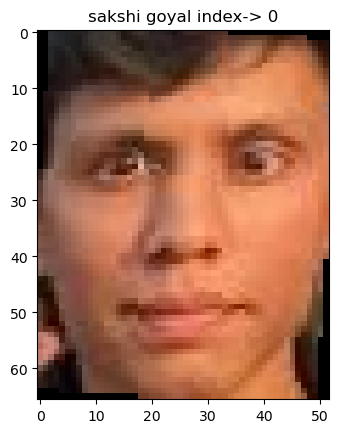

///
///
Abhis            -17.76041603088379
Akank            -26.483137130737305
Akash            -15.473308563232422
Anmol            -31.417272567749023
Harsh            -28.66877555847168
Navee            -0.0011263700434938073
Nisch            -6.854606628417969
Ritan            -21.206756591796875
YASH             -33.88845443725586
abhay            -10.815261840820312
akshi            -25.434804916381836
anish            -26.53481101989746
deepa            -34.103057861328125
deepa            -11.29196548461914
harsh            -24.192331314086914
mradu            -18.288835525512695
mukes            -23.82291603088379
saksh            -14.632678031921387
tanis            -10.177672386169434
the index with highest value is Naveen  -> -0.0011263700434938073


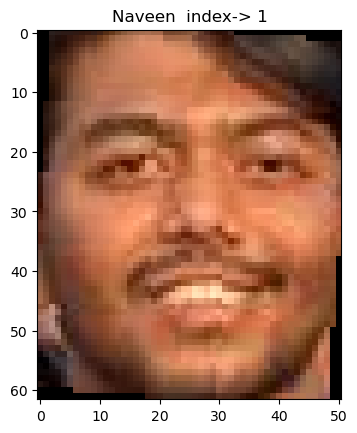

///
///
Abhis            -1.6805126667022705
Akank            -1.5458953380584717
Akash            -22.893205642700195
Anmol            -14.254727363586426
Harsh            -8.525273323059082
Navee            -13.007612228393555
Nisch            -19.5594539642334
Ritan            -0.8449499607086182
YASH             -3.446943759918213
abhay            -24.40134620666504
akshi            -3.718920946121216
anish            -5.031700134277344
deepa            -2.224520206451416
deepa            -23.592199325561523
harsh            -31.66254997253418
mradu            -14.694902420043945
mukes            -9.785510063171387
saksh            -11.216079711914062
tanis            -14.749659538269043
the index with highest value is Ritansh Singhal -> -0.8449499607086182


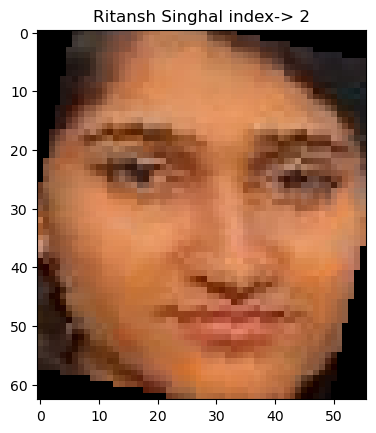

///
///
Abhis            -23.5094051361084
Akank            -28.329914093017578
Akash            -17.946542739868164
Anmol            -25.838022232055664
Harsh            -10.689837455749512
Navee            -2.6959471702575684
Nisch            -0.07078611105680466
Ritan            -7.809944152832031
YASH             -44.926307678222656
abhay            -18.256486892700195
akshi            -32.73936462402344
anish            -22.09953498840332
deepa            -34.427223205566406
deepa            -23.29693031311035
harsh            -15.629611015319824
mradu            -18.15167999267578
mukes            -15.625343322753906
saksh            -21.322006225585938
tanis            -7.748027324676514
the index with highest value is Nischal -> -0.07078611105680466


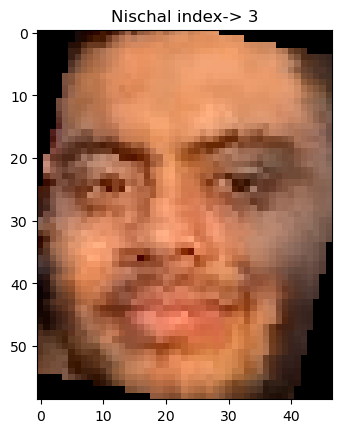

///
///
Abhis            -16.88465118408203
Akank            -23.859886169433594
Akash            -19.457828521728516
Anmol            -19.966466903686523
Harsh            -6.603645324707031
Navee            -0.008457320742309093
Nisch            -14.48403263092041
Ritan            -10.35036849975586
YASH             -21.136680603027344
abhay            -5.084321975708008
akshi            -19.811429977416992
anish            -14.088872909545898
deepa            -21.435768127441406
deepa            -14.656213760375977
harsh            -16.344053268432617
mradu            -8.857077598571777
mukes            -7.3227858543396
saksh            -10.704444885253906
tanis            -11.156099319458008
the index with highest value is Naveen  -> -0.008457320742309093


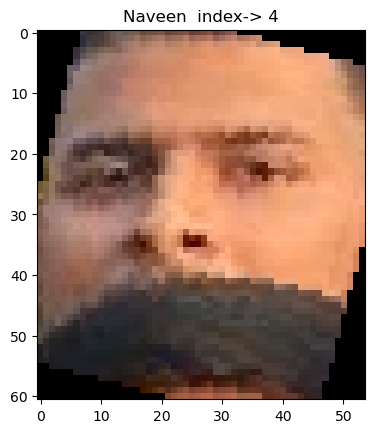

///
///
Abhis            -31.36060333251953
Akank            -24.021717071533203
Akash            -15.419851303100586
Anmol            -13.558194160461426
Harsh            -11.965805053710938
Navee            -17.612350463867188
Nisch            -16.471845626831055
Ritan            -21.10585594177246
YASH             -24.087528228759766
abhay            -16.407007217407227
akshi            -33.63770294189453
anish            -28.78642463684082
deepa            -26.441116333007812
deepa            -27.12110137939453
harsh            -8.106198947643861e-06
mradu            -33.554481506347656
mukes            -33.54608917236328
saksh            -24.637285232543945
tanis            -20.91152000427246
the index with highest value is harsh tripathi -> -8.106198947643861e-06


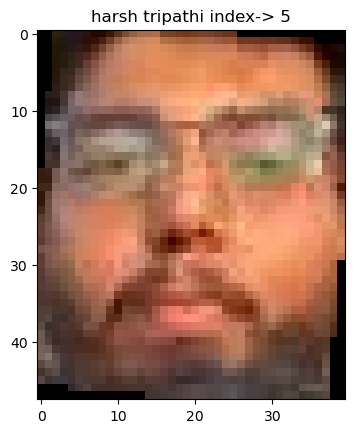

///
///
Abhis            -16.918556213378906
Akank            -24.859092712402344
Akash            -41.6962890625
Anmol            -20.278547286987305
Harsh            -25.33562469482422
Navee            -21.766643524169922
Nisch            -29.305809020996094
Ritan            -17.318275451660156
YASH             -16.856287002563477
abhay            -26.43246078491211
akshi            -15.593076705932617
anish            -39.681427001953125
deepa            -15.238935470581055
deepa            -30.522396087646484
harsh            -38.765472412109375
mradu            -24.99289321899414
mukes            -25.994831085205078
saksh            -4.768370445162873e-07
tanis            -23.73265838623047
the index with highest value is sakshi goyal -> -4.768370445162873e-07


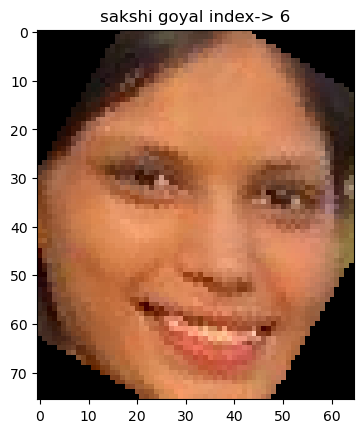

///
///
Abhis            -5.894143104553223
Akank            -3.5914134979248047
Akash            -14.15616512298584
Anmol            -22.89778709411621
Harsh            -8.595273971557617
Navee            -18.013835906982422
Nisch            -0.909406840801239
Ritan            -15.329105377197266
YASH             -11.601362228393555
abhay            -14.28078556060791
akshi            -17.212369918823242
anish            -9.709921836853027
deepa            -0.5692045092582703
deepa            -14.351585388183594
harsh            -10.276923179626465
mradu            -9.240375518798828
mukes            -8.07731819152832
saksh            -8.356431007385254
tanis            -11.270011901855469
the index with highest value is deepal -> -0.5692045092582703


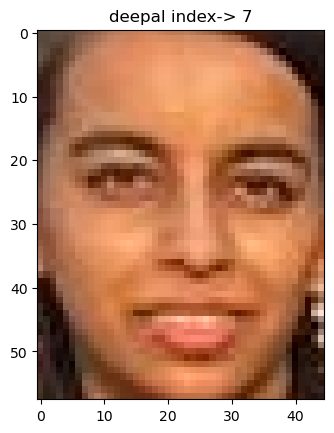

///
///
Abhis            -12.559942245483398
Akank            -21.10661506652832
Akash            -13.96088981628418
Anmol            -0.11478230357170105
Harsh            -11.082124710083008
Navee            -15.740819931030273
Nisch            -12.983827590942383
Ritan            -9.641464233398438
YASH             -2.2608981132507324
abhay            -19.826881408691406
akshi            -28.11994743347168
anish            -21.42903709411621
deepa            -19.235502243041992
deepa            -23.73293685913086
harsh            -5.497776985168457
mradu            -25.227859497070312
mukes            -24.737892150878906
saksh            -23.38623046875
tanis            -20.676692962646484
the index with highest value is Anmol -> -0.11478230357170105


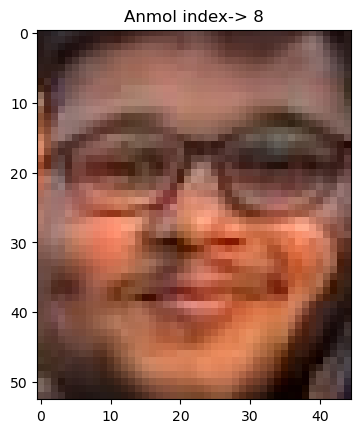

///
///
Abhis            -10.094057083129883
Akank            -10.026634216308594
Akash            -2.0848357677459717
Anmol            -10.462924003601074
Harsh            -11.957636833190918
Navee            -3.691818952560425
Nisch            -0.17555879056453705
Ritan            -4.570315361022949
YASH             -7.204498767852783
abhay            -7.7482218742370605
akshi            -25.264894485473633
anish            -19.465068817138672
deepa            -21.88549041748047
deepa            -9.89065170288086
harsh            -18.6281681060791
mradu            -20.121112823486328
mukes            -10.362405776977539
saksh            -26.360904693603516
tanis            -10.571259498596191
the index with highest value is Nischal -> -0.17555879056453705


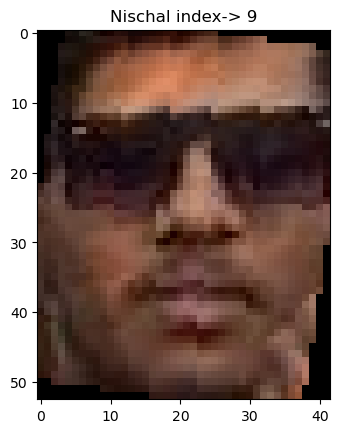

///
///
Abhis            -10.818502426147461
Akank            -13.089338302612305
Akash            -0.29682859778404236
Anmol            -19.510944366455078
Harsh            -17.58437728881836
Navee            -9.199252128601074
Nisch            -1.437158226966858
Ritan            -14.570180892944336
YASH             -14.578837394714355
abhay            -9.368112564086914
akshi            -23.560928344726562
anish            -13.575859069824219
deepa            -13.98615837097168
deepa            -5.055441379547119
harsh            -12.672240257263184
mradu            -5.123998165130615
mukes            -14.859739303588867
saksh            -12.443842887878418
tanis            -5.008535385131836
the index with highest value is Akash -> -0.29682859778404236


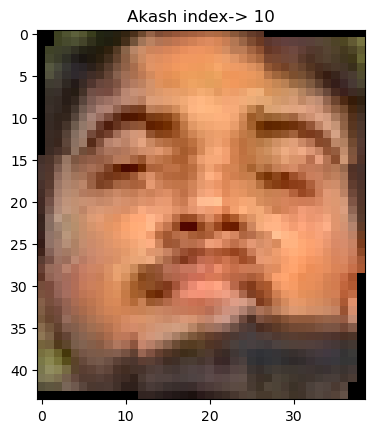

///
///
Abhis            -3.087864637374878
Akank            -24.427804946899414
Akash            -12.694849967956543
Anmol            -16.001771926879883
Harsh            -18.608957290649414
Navee            -3.791485548019409
Nisch            -0.07066215574741364
Ritan            -22.695270538330078
YASH             -22.187257766723633
abhay            -16.79421043395996
akshi            -16.660717010498047
anish            -20.329875946044922
deepa            -30.808229446411133
deepa            -11.7416353225708
harsh            -17.667423248291016
mradu            -15.873443603515625
mukes            -15.858053207397461
saksh            -9.965123176574707
tanis            -12.515498161315918
the index with highest value is Nischal -> -0.07066215574741364


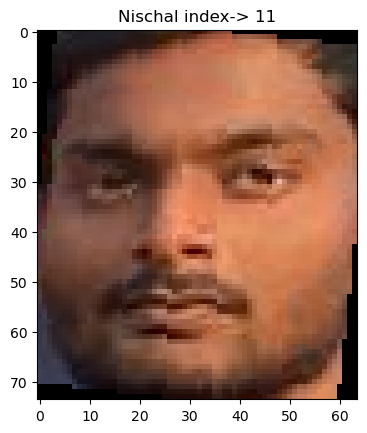

///
///
Abhis            -41.08707809448242
Akank            -29.958845138549805
Akash            -25.810279846191406
Anmol            -19.194597244262695
Harsh            -7.423237323760986
Navee            -20.37003517150879
Nisch            -10.690567016601562
Ritan            -31.2011775970459
YASH             -34.815006256103516
abhay            -25.55567741394043
akshi            -38.84646224975586
anish            -31.44384002685547
deepa            -28.53126335144043
deepa            -27.895784378051758
harsh            -0.0006201728247106075
mradu            -33.103267669677734
mukes            -28.3121337890625
saksh            -33.504798889160156
tanis            -30.39100456237793
the index with highest value is harsh tripathi -> -0.0006201728247106075


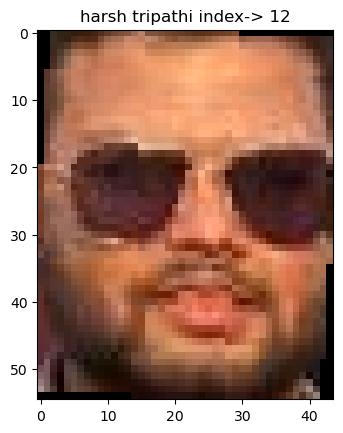

///
///
Abhis            -22.919147491455078
Akank            -14.67449951171875
Akash            -23.49425506591797
Anmol            -27.87688446044922
Harsh            -15.859943389892578
Navee            -28.611431121826172
Nisch            -2.748957872390747
Ritan            -13.8428373336792
YASH             -14.823312759399414
abhay            -23.360950469970703
akshi            -16.456859588623047
anish            -13.637445449829102
deepa            -0.06613834947347641
deepa            -35.09159851074219
harsh            -17.169261932373047
mradu            -25.173625946044922
mukes            -13.927069664001465
saksh            -16.748947143554688
tanis            -18.55374526977539
the index with highest value is deepal -> -0.06613834947347641


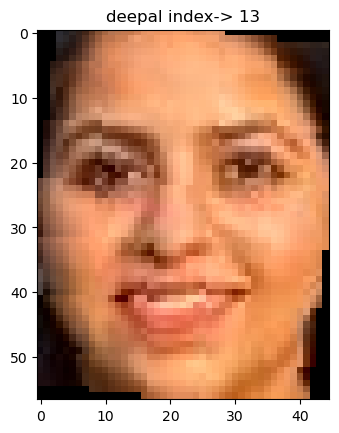

///
///
Abhis            -4.219153881072998
Akank            -5.632375240325928
Akash            -4.174105167388916
Anmol            -15.251435279846191
Harsh            -0.7639757394790649
Navee            -9.5900297164917
Nisch            -4.629861354827881
Ritan            -0.7723985910415649
YASH             -3.9441123008728027
abhay            -12.108086585998535
akshi            -10.027222633361816
anish            -13.279858589172363
deepa            -13.296380996704102
deepa            -9.931357383728027
harsh            -16.185977935791016
mradu            -5.382847309112549
mukes            -6.074721813201904
saksh            -6.28773832321167
tanis            -7.4940266609191895
the index with highest value is Harsh Gupta -> -0.7639757394790649


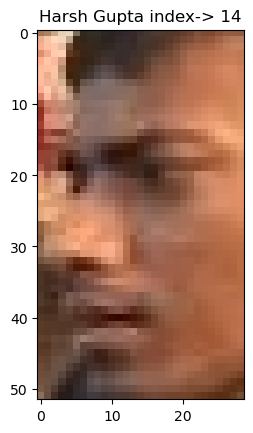

///
///
Abhis            -4.1370649337768555
Akank            -22.107271194458008
Akash            -15.680082321166992
Anmol            -10.802621841430664
Harsh            -11.092811584472656
Navee            -12.886443138122559
Nisch            -0.01748071052134037
Ritan            -11.50446891784668
YASH             -13.772259712219238
abhay            -11.975332260131836
akshi            -16.726388931274414
anish            -19.502445220947266
deepa            -22.191736221313477
deepa            -21.875141143798828
harsh            -14.86614990234375
mradu            -6.650230407714844
mukes            -11.578924179077148
saksh            -24.819108963012695
tanis            -20.7666072845459
the index with highest value is Nischal -> -0.01748071052134037


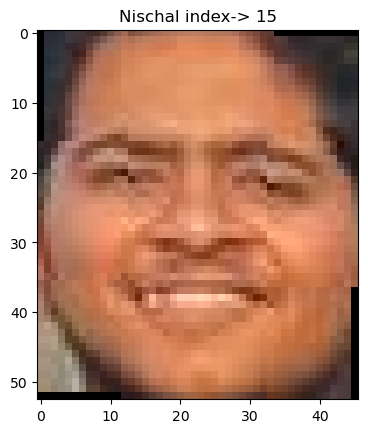

///
///
Abhis            -4.583827495574951
Akank            -3.5927464962005615
Akash            -0.2476852387189865
Anmol            -4.626791000366211
Harsh            -4.299478530883789
Navee            -9.814587593078613
Nisch            -4.483844757080078
Ritan            -7.090997695922852
YASH             -2.7461097240448
abhay            -9.40344524383545
akshi            -19.403667449951172
anish            -7.558183193206787
deepa            -16.78628921508789
deepa            -3.7444117069244385
harsh            -6.261656284332275
mradu            -2.8875303268432617
mukes            -14.977073669433594
saksh            -9.660011291503906
tanis            -14.514962196350098
the index with highest value is Akash -> -0.2476852387189865


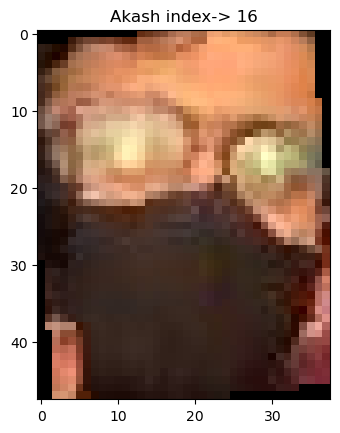

///
///
Abhis            -22.867368698120117
Akank            -21.45886993408203
Akash            -0.035830192267894745
Anmol            -12.8490629196167
Harsh            -6.299544811248779
Navee            -14.463364601135254
Nisch            -8.83492374420166
Ritan            -12.20254135131836
YASH             -3.7034595012664795
abhay            -16.239126205444336
akshi            -34.8656005859375
anish            -13.883135795593262
deepa            -24.59663200378418
deepa            -10.652139663696289
harsh            -4.7627434730529785
mradu            -23.481733322143555
mukes            -19.597383499145508
saksh            -33.26278305053711
tanis            -20.013038635253906
the index with highest value is Akash -> -0.035830192267894745


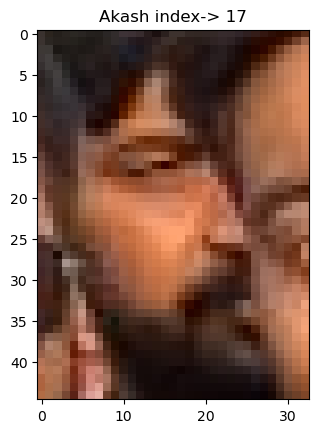

///


In [170]:
img_path="data/exp/WhatsApp Image 2023-12-10 at 22.59.22.jpeg"
import matplotlib.pyplot as plt
faces = RetinaFace.extract_faces(img_path = img_path, align = True)
for i in range(len(faces)):
    if i==i:
        print("///")
        imgf=standard_transform(faces[i])
        imgf=model(imgf.to(device).unsqueeze(0))
        predictions=predict(imgf)
        _, pred_labels = torch.max(predictions, 1)
        for j in range(len(ClassList)):
            prediction=np.array(predictions.detach().cpu().squeeze())
            print(f"{name_from_index(j)[0:5]}            {prediction[j]}")
        print(f"the index with highest value is {name_from_index(pred_labels.item())} -> {prediction[pred_labels]}")
        name=name_from_index(pred_labels.item())
        plt.imshow(faces[i])
        plt.title(f"{name} index-> {i}")
        plt.show()
        print("///")


In [155]:
ClassList

{'Abhishek': 0,
 'Akanksha Pant': 1,
 'Akash': 2,
 'Anmol': 3,
 'Harsh Gupta': 4,
 'Naveen ': 5,
 'Nischal': 6,
 'Ritansh Singhal': 7,
 'YASH GARG': 8,
 'abhay': 9,
 'akshita ': 10,
 'anisha': 11,
 'deepal': 12,
 'deepanshu ': 13,
 'harsh tripathi': 14,
 'mradul': 15,
 'mukesh': 16,
 'sakshi goyal': 17,
 'tanishk mittal': 18}